In [29]:

import pandas as pd
import pybaseball
pybaseball.cache.enable()
print(pd.__version__)
from pybaseball import statcast
balldata = statcast(start_dt='2025-01-01',end_dt='2025-07-24')
balldata = pd.DataFrame(balldata)
from sklearn.model_selection import train_test_split as tts
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np

2.3.1
This is a large query, it may take a moment to complete
Skipping offseason dates


100%|██████████| 132/132 [00:03<00:00, 39.20it/s]
/sciclone/home/tdfelton/.conda/envs/baseball2/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [30]:
balldata = pd.DataFrame(balldata)
balldata = balldata[balldata['game_type'] == 'R']
balldata.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2548,SI,2025-07-23,83.5,-3.61,1.37,"Rogers, Tyler",686948,643511,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,14,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,X,6,ground_ball,1,2,2025,-0.13,-0.77,1.04,2.47,<NA>,595777,<NA>,2,9,Bot,118.82,161.3,<NA>,...,9,3,9,9,3,3,9,Strategic,Strategic,334,0.0,-0.211,66.5,5.6,0.137,0.211,88.0,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,4.03,0.13,-0.13,<NA>,-15.27946,19.065945,42.083731,21.13013,22.616788
2681,SI,2025-07-23,84.9,-3.84,1.42,"Rogers, Tyler",686948,643511,None,ball,<NA>,<NA>,<NA>,<NA>,12,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,B,<NA>,None,0,2,2025,-0.12,-0.76,0.06,3.61,<NA>,595777,<NA>,2,9,Bot,<NA>,<NA>,<NA>,...,9,3,9,9,3,3,9,Standard,Strategic,323,0.0,0.018,<NA>,<NA>,<NA>,-0.018,<NA>,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.92,0.12,-0.12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2764,SL,2025-07-23,74.6,-3.87,1.38,"Rogers, Tyler",686948,643511,None,swinging_strike,<NA>,<NA>,<NA>,<NA>,11,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,S,<NA>,None,0,1,2025,0.57,0.77,-0.41,3.51,<NA>,595777,<NA>,2,9,Bot,<NA>,<NA>,<NA>,...,9,3,9,9,3,3,9,Standard,Strategic,113,0.0,-0.067,68.0,5.4,<NA>,0.067,<NA>,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.32,-0.57,0.57,<NA>,-2.349464,47.133901,22.419802,39.541169,10.095727
2862,SI,2025-07-23,84.1,-3.7,1.45,"Rogers, Tyler",686948,643511,None,called_strike,<NA>,<NA>,<NA>,<NA>,2,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,S,<NA>,None,0,0,2025,-0.21,-0.68,0.12,3.01,<NA>,595777,<NA>,2,9,Bot,<NA>,<NA>,<NA>,...,9,3,9,9,3,3,9,Standard,Strategic,319,0.0,-0.04,<NA>,<NA>,<NA>,0.04,<NA>,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.89,0.21,-0.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2883,SI,2025-07-23,83.5,-3.68,1.37,"Rogers, Tyler",621566,643511,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,8,Matt Olson lines out to left fielder Heliot Ra...,R,L,R,ATL,SF,X,7,line_drive,0,1,2025,-0.16,-0.79,0.0,1.77,<NA>,595777,<NA>,1,9,Bot,67.48,95.5,<NA>,...,9,3,9,9,3,3,9,Strategic,Standard,327,-0.003,-0.226,71.4,7.4,0.793,0.226,99.7,-6,-6,0.003,0.003,34,31,35,31,1,4,<NA>,<NA>,<NA>,<NA>,4.05,0.16,-0.16,<NA>,-1.201536,11.960876,36.163226,38.448058,27.27669


In [31]:
populated_columns = balldata.columns[balldata.notna().any()].tolist()
balldata = balldata[populated_columns]
balldata.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,vx0,vy0,vz0,ax,ay,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2548,SI,2025-07-23,83.5,-3.61,1.37,"Rogers, Tyler",686948,643511,field_out,hit_into_play,14,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,X,6,ground_ball,1,2,2025,-0.13,-0.77,1.04,2.47,<NA>,595777,<NA>,2,9,Bot,118.82,161.3,10.807644,-120.7381,10.35401,-3.072318,19.634793,...,9,3,9,9,3,3,9,Strategic,Strategic,334,0.0,-0.211,66.5,5.6,0.137,0.211,88.0,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,4.03,0.13,-0.13,<NA>,-15.27946,19.065945,42.083731,21.13013,22.616788
2681,SI,2025-07-23,84.9,-3.84,1.42,"Rogers, Tyler",686948,643511,None,ball,12,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,B,<NA>,None,0,2,2025,-0.12,-0.76,0.06,3.61,<NA>,595777,<NA>,2,9,Bot,<NA>,<NA>,9.263718,-122.64537,12.811935,-2.747086,19.989374,...,9,3,9,9,3,3,9,Standard,Strategic,323,0.0,0.018,<NA>,<NA>,<NA>,-0.018,<NA>,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.92,0.12,-0.12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2764,SL,2025-07-23,74.6,-3.87,1.38,"Rogers, Tyler",686948,643511,None,swinging_strike,11,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,S,<NA>,None,0,1,2025,0.57,0.77,-0.41,3.51,<NA>,595777,<NA>,2,9,Bot,<NA>,<NA>,6.027419,-108.027488,10.125357,3.634257,16.22121,...,9,3,9,9,3,3,9,Standard,Strategic,113,0.0,-0.067,68.0,5.4,<NA>,0.067,<NA>,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.32,-0.57,0.57,<NA>,-2.349464,47.133901,22.419802,39.541169,10.095727
2862,SI,2025-07-23,84.1,-3.7,1.45,"Rogers, Tyler",686948,643511,None,called_strike,2,"Drake Baldwin grounds out, shortstop Willy Ada...",R,L,R,ATL,SF,S,<NA>,None,0,0,2025,-0.21,-0.68,0.12,3.01,<NA>,595777,<NA>,2,9,Bot,<NA>,<NA>,9.208409,-121.668658,11.21799,-3.601792,19.058996,...,9,3,9,9,3,3,9,Standard,Strategic,319,0.0,-0.04,<NA>,<NA>,<NA>,0.04,<NA>,-6,-6,0.0,0.0,34,24,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.89,0.21,-0.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2883,SI,2025-07-23,83.5,-3.68,1.37,"Rogers, Tyler",621566,643511,field_out,hit_into_play,8,Matt Olson lines out to left fielder Heliot Ra...,R,L,R,ATL,SF,X,7,line_drive,0,1,2025,-0.16,-0.79,0.0,1.77,<NA>,595777,<NA>,1,9,Bot,67.48,95.5,8.667134,-120.964665,8.786908,-2.999886,20.373566,...,9,3,9,9,3,3,9,Strategic,Standard,327,-0.003,-0.226,71.4,7.4,0.793,0.226,99.7,-6,-6,0.003,0.003,34,31,35,31,1,4,<NA>,<NA>,<NA>,<NA>,4.05,0.16,-0.16,<NA>,-1.201536,11.960876,36.163226,38.448058,27.27669


In [39]:
hits = ['single','double','triple','home_run']
lineups_y = balldata['events'].isin(hits).astype(int)
lineups_y.describe()
lineups_x = balldata.drop(columns=['events'])
lineups_x = lineups_x.drop(
    columns=[col for col in lineups_x.columns if 'depreciated' in col or 'legacy' in col or 'estimated' in col]
)

# Drop specific additional columns
cols_to_drop = [
    'type', 'player_name', 'des', 'home_team', 'game_year', 'away_team', 'game_type',
    'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle',
    'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score','bat_win_dif'
    'delta_home_win_exp', 'delta_run_exp', 'delta_pitcher_run_exp','bat_score','fld_score',
    'home_score_diff', 'home_win_exp', 'on_3b', 'on_2b', 'on_1b','pitch_name','home_score','away_score','description',
    'hit_location','bb_type','hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','delta_home_win_exp'
]
lineups_x = lineups_x.drop(columns=[col for col in cols_to_drop if col in lineups_x.columns])
print(lineups_x.shape,lineups_y.shape)
lineups_x.head()

(447150, 67) (447150,)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,zone,stand,p_throws,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,outs_when_up,inning,inning_topbot,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,at_bat_number,pitch_number,if_fielding_alignment,of_fielding_alignment,spin_axis,bat_speed,swing_length,hyper_speed,bat_score_diff,bat_win_exp,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2548,SI,2025-07-23,83.5,-3.61,1.37,686948,643511,14,L,R,1,2,-0.13,-0.77,1.04,2.47,2,9,Bot,10.807644,-120.7381,10.35401,-3.072318,19.634793,-41.820036,3.35,1.64,83.0,2018,6.0,777041,672275,642086,689172,669477,642715,671218,682641,573262,54.54,82,4,Strategic,Strategic,334,66.5,5.6,88.0,-6,0.0,35,24,1,4,<NA>,<NA>,<NA>,<NA>,4.03,0.13,-0.13,<NA>,-15.27946,19.065945,42.083731,21.13013,22.616788
2681,SI,2025-07-23,84.9,-3.84,1.42,686948,643511,12,L,R,0,2,-0.12,-0.76,0.06,3.61,2,9,Bot,9.263718,-122.64537,12.811935,-2.747086,19.989374,-42.3429,3.48,1.58,84.5,2033,6.0,777041,672275,642086,689172,669477,642715,671218,682641,573262,54.47,82,3,Standard,Strategic,323,<NA>,<NA>,<NA>,-6,0.0,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.92,0.12,-0.12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2764,SL,2025-07-23,74.6,-3.87,1.38,686948,643511,11,L,R,0,1,0.57,0.77,-0.41,3.51,2,9,Bot,6.027419,-108.027488,10.125357,3.634257,16.22121,-27.852381,3.35,1.64,74.3,2397,6.0,777041,672275,642086,689172,669477,642715,671218,682641,573262,54.49,82,2,Standard,Strategic,113,68.0,5.4,<NA>,-6,0.0,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.32,-0.57,0.57,<NA>,-2.349464,47.133901,22.419802,39.541169,10.095727
2862,SI,2025-07-23,84.1,-3.7,1.45,686948,643511,2,L,R,0,0,-0.21,-0.68,0.12,3.01,2,9,Bot,9.208409,-121.668658,11.21799,-3.601792,19.058996,-41.162974,3.55,1.58,84.0,1999,6.1,777041,672275,642086,689172,669477,642715,671218,682641,573262,54.38,82,1,Standard,Strategic,319,<NA>,<NA>,<NA>,-6,0.0,35,24,1,4,<NA>,<NA>,<NA>,<NA>,3.89,0.21,-0.21,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2883,SI,2025-07-23,83.5,-3.68,1.37,621566,643511,8,L,R,0,1,-0.16,-0.79,0.0,1.77,1,9,Bot,8.667134,-120.964665,8.786908,-2.999886,20.373566,-41.781249,3.58,1.77,82.9,1961,5.8,777041,672275,642086,689172,669477,642715,671218,682641,573262,54.65,81,2,Strategic,Standard,327,71.4,7.4,99.7,-6,0.003,35,31,1,4,<NA>,<NA>,<NA>,<NA>,4.05,0.16,-0.16,<NA>,-1.201536,11.960876,36.163226,38.448058,27.27669


In [40]:
lineups_x['game_year'] = pd.to_datetime(lineups_x['game_date']).dt.year
lineups_x['game_month'] = pd.to_datetime(lineups_x['game_date']).dt.month
lineups_x['game_day'] = pd.to_datetime(lineups_x['game_date']).dt.day
# Then drop the original datetime column
lineups_x = lineups_x.drop(columns=['game_date'])


In [43]:
categorical_cols = ['game_year','game_month','game_day','pitch_type','batter','pitcher','stand','p_throws',
                    'balls','strikes','inning','inning_topbot','game_pk','fielder_2',
                    'fielder_3','fielder_4','fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','pitch_number',
                    'at_bat_number','if_fielding_alignment','of_fielding_alignment','age_pit','age_bat','n_thruorder_pitcher',
                    'n_priorpa_thisgame_player_at_bat','pitcher_days_since_prev_game','batter_days_since_prev_game',
                    'pitcher_days_until_next_game','batter_days_until_next_game']
# See which categorical columns are missing from the DataFrame


lineups_x[categorical_cols] = lineups_x[categorical_cols].astype(str)

In [44]:
x_feat_train, x_feat_test, y_feat_train, y_feat_test = tts(lineups_x, lineups_y, test_size = 0.2)
model = CatBoostClassifier(verbose=100)
model.fit(x_feat_train,y_feat_train,cat_features=categorical_cols)

Learning rate set to 0.126852
0:	learn: 0.4599509	total: 93.1ms	remaining: 1m 33s
100:	learn: 0.1077067	total: 10.2s	remaining: 1m 30s
200:	learn: 0.0987198	total: 20.9s	remaining: 1m 22s
300:	learn: 0.0951957	total: 31s	remaining: 1m 11s
400:	learn: 0.0924106	total: 41.3s	remaining: 1m 1s
500:	learn: 0.0902107	total: 51.6s	remaining: 51.4s
600:	learn: 0.0863468	total: 1m 2s	remaining: 41.4s
700:	learn: 0.0842782	total: 1m 12s	remaining: 31.1s
800:	learn: 0.0820830	total: 1m 22s	remaining: 20.6s
900:	learn: 0.0793204	total: 1m 33s	remaining: 10.3s
999:	learn: 0.0771092	total: 1m 43s	remaining: 0us


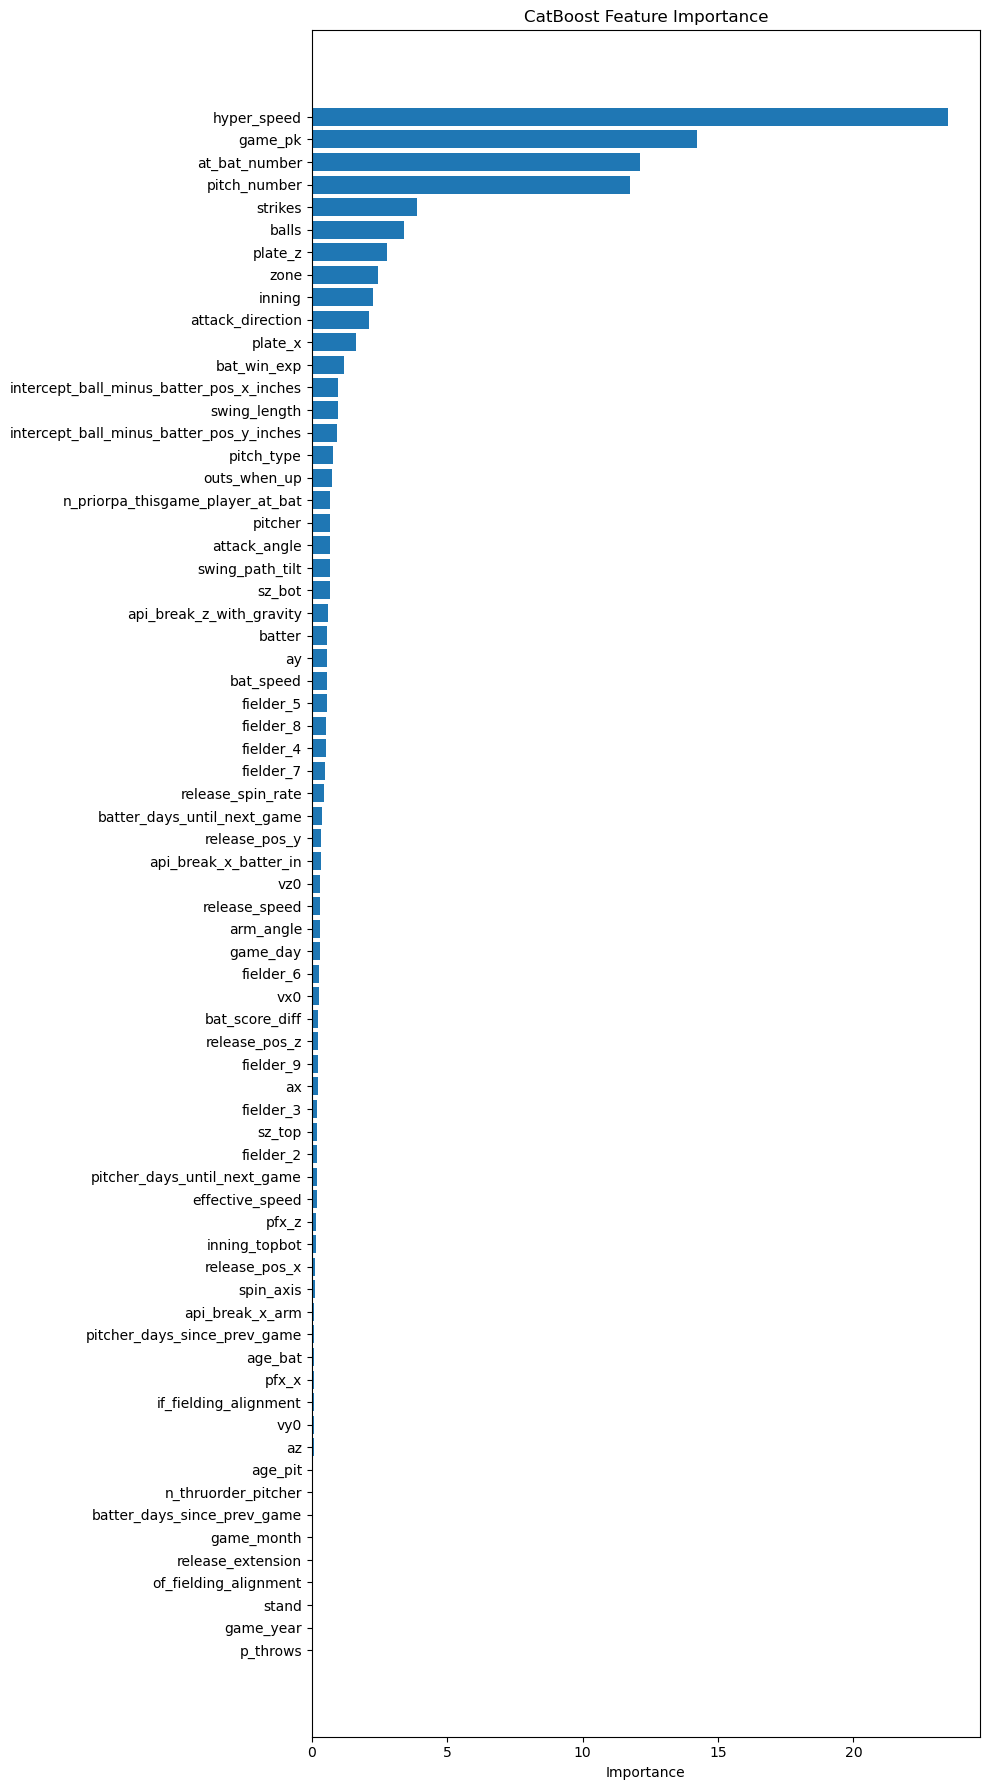

In [45]:
importances = model.get_feature_importance()
features = x_feat_train.columns

# Sort and plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 18))
plt.barh(np.array(features)[indices], np.array(importances)[indices])
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()